In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.animation as animation

In [8]:
# Set up the movie writer
framerate = 2 # 24 frames per second
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Collective Motion of Particles', artist='DvH', comment='')
writer = FFMpegWriter(fps=framerate, metadata=metadata)


5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


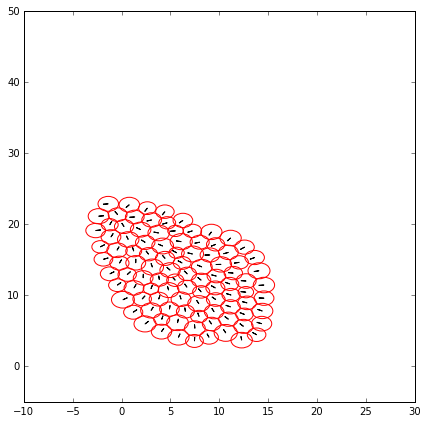

In [12]:
#Parameters

time = 0
timestep = 0.20
N = 100 #amount of particles
width = 10 #width of initial lattice
aR = 1 #average radius
r = aR*2 #lattice space
krep = 1 #repulsion coefficient
dzeta = 1
tau = dzeta / krep #characteristic timestep
chi = 1

lambdaFin = 0.3
Fin = lambdaFin * krep * aR
lambdaS = 0.08
Fself = lambdaS * krep * aR

lambdaTin = 3
Tin = lambdaTin * krep * chi / dzeta
lambdan = 0.03
Tnoise = (lambdan * 2 * krep * chi**2 / (dzeta * timestep))**0.5
lambdaa = 0.3
Talign = lambdaa * krep * chi / dzeta

#intialise lattice and particle properties

radius = np.random.normal(aR,aR/10,N) #radius matrix Nx1
normrad = radius/aR
area = np.pi * radius**2
initial_direction = np.zeros(N) #direction matrix Nx1
velocity = np.zeros(N)
angular_velocity = np.zeros(N)

pos = np.zeros((N,2)) #position matrix Nx2
x = []
y = []
ystep = np.linspace(0,N/width-1,N/width)*r

for i in ystep:
    x = np.append(x,np.linspace(0,width-1,width)*r)
    y = np.append(y,np.ones(width)*i)

for i in range(N):
        pos[i,0] = x[i] + np.random.uniform(-r/10,r/10)
        pos[i,1] = y[i] + np.random.uniform(-r/10,r/10)
        initial_direction[i] = np.random.uniform(-np.pi/4,np.pi/4) + np.pi/2

#plt.scatter(pos[:,0],pos[:,1],s=100*area,alpha=0.5)
#plt.show()

direction = initial_direction

#fig = plt.figure(figsize=(7,7))
#ax = fig.add_subplot(111)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
with writer.saving(fig, "anim.mp4", 100):

    while time <= 101:

        if round(time,3)%5 == 0:

                ax.cla()
                ax = plt.gca()
                for i in range(0,N):
                    circle = plt.Circle((pos[i,0], pos[i,1]), radius[i], color = 'r', fill=False)
                    ax.add_artist(circle)
                    ax.arrow(pos[i,0], pos[i,1], 0.5*np.cos(direction[i]), 0.5*np.sin(direction[i]))
                ax.set_xlim((-10, 30))
                ax.set_ylim((-5, 50))
                writer.grab_frame()
                #plt.show()
                #plt.close()
                #ax.scatter(pos[:,0],pos[:,1])
                #display.clear_output(wait=True)
                #display.display(fig)

        #Determine neighbours
        boundary = np.zeros(N)
        thetaout = np.zeros(N)
        thetadiff = np.zeros(N)
        directiondiff = np.zeros(N)
        Frepx = np.zeros(N)
        Frepy = np.zeros(N)

        for i in range(N):
            angles = []
            neighbours = []
            overlap = []
            anglediff = []

            for j in range(N):
                if i == j:
                    continue
                d = ((pos[i,0]-pos[j,0])**2 + (pos[i,1]-pos[j,1])**2)**0.5
                if d < 2.7*aR:
                    neighbours = np.append(neighbours,j)
                    angles = np.append(angles,-(np.arctan2(pos[j,0]-pos[i,0], pos[j,1]-pos[i,1])-0.5*np.pi)%(np.pi*2))
                    anglediff = np.append(anglediff,direction[j]-direction[i])

                    if d < abs(radius[i] - radius[j]):
                        overlap = np.append(overlap,(np.pi * radius[i]**2))
                    elif d < (radius[i] + radius[j]):
                        Aij = (radius[j]**2 * np.arccos((d**2 + radius[j]**2 - radius[i]**2)/(2*d*radius[j])) 
                            + radius[i]**2 * np.arccos((d**2 + radius[i]**2 - radius[j]**2)/(2*d*radius[i])) 
                            - 0.5*((-d+radius[i]+radius[j])*(d-radius[i]+radius[j])*(d+radius[i]-radius[j])*(d+radius[i]+radius[j]))**0.5)
                        overlap = np.append(overlap,Aij)
                    else:
                        overlap = np.append(overlap,0)

                    Frepx[i] += krep * overlap[len(overlap)-1] * np.cos(angles[len(angles)-1])
                    Frepy[i] += krep * overlap[len(overlap)-1] * np.sin(angles[len(angles)-1])

            angles = np.sort(angles)
            for k in range(len(neighbours)):
                angle = (angles[(k+1)%(len(neighbours))] - angles[k])%(2*np.pi)
                if angle > np.pi:
                    boundary[i] = 1.
                    thetaout[i] = angle
                    thetadiff[i] = (angles[k] - ((2*np.pi - angle)/2)) - direction[i]

            directiondiff[i] = np.sum(anglediff)

        #Force and torque

        for i in range(N):
            F_boun = Fin * boundary[i] * (thetaout[i]-np.pi)
            T_boun = Tin * thetadiff[i] * boundary[i]
            T_noise = Tnoise * np.random.uniform(-1,1)
            T_align = Talign * directiondiff[i]

            Fx = np.cos(direction[i]) * (Fself + F_boun) - Frepx[i]
            Fy = np.sin(direction[i]) * (Fself + F_boun) - Frepy[i]
            T = T_boun + T_noise + T_align

            vx = Fx/(normrad[i] * dzeta)
            vy = Fy/(normrad[i] * dzeta)
            omega = T/(normrad[i]**2 * chi)

            pos[i,0] += vx * timestep
            pos[i,1] += vy * timestep
            direction[i] += omega * timestep

        time += timestep
        if round(time,3)%5 == 0:
            print(round(time,3))
        


In [8]:
(round(1.9999,3)

2.0